In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.7MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 1.0MB 19.3MB/s 
     |████████████████████████████████| 358kB 30.3MB/s 
     |████████████████████████████████| 40kB 6.6MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
     |████████████████████████████████| 40kB 6.4MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 2.6MB 17.8MB/s 
Mounted at /content/gdrive


In [3]:

from fastbook import *

In [4]:
# load ImageNet dataset 
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [7]:
# load the data in DataLoaders
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [6]:
# train the dataset on resnet50 model
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.596747,1.720929,0.423450,05:59
1,1.184623,1.966148,0.463406,05:58
2,0.921344,1.336894,0.641524,05:58
3,0.718420,0.736882,0.766990,05:59
4,0.596856,0.558073,0.821509,05:58


In [7]:
# find the mean and std deviation of the data
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4498, 0.4466, 0.4205], device='cuda:0'),
 TensorImage([0.2708, 0.2714, 0.2978], device='cuda:0'))

In [8]:
# normalise the dataset 
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [9]:
dls = get_dls(64, 224)

In [10]:
# find the mean and std. dev after normalising 
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.1236, -0.1011, -0.0317], device='cuda:0'),
 TensorImage([1.2155, 1.2289, 1.3228], device='cuda:0'))

In [11]:
# train the model on normalised dataset 
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.707703,1.982533,0.403659,05:59
1,1.281292,1.156322,0.637416,05:59
2,0.993508,1.038899,0.644884,05:58
3,0.737561,0.757033,0.770724,05:59
4,0.604150,0.578785,0.824122,05:59


In [12]:
# train the model using multiple batches 
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.833293,2.511775,0.418596,02:44
1,1.269836,1.231729,0.625467,02:46
2,0.953794,0.721160,0.774085,02:45
3,0.740773,0.600413,0.811800,02:43


Test Time Augmentation 

In [13]:
# fine tune the model 
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.804856,1.182773,0.637789,05:59


epoch,train_loss,valid_loss,accuracy,time
0,0.635744,0.685352,0.788648,05:59
1,0.632169,0.959301,0.730769,06:00
2,0.569441,0.588218,0.814414,06:00
3,0.462144,0.486821,0.846901,06:00
4,0.428515,0.463443,0.864451,06:00


In [14]:
# perform test time augmentation 
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8689320683479309

MixUp

In [12]:
# Mixup of the images

items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(after_item=[ToTensor(), IntToFloatTensor()])

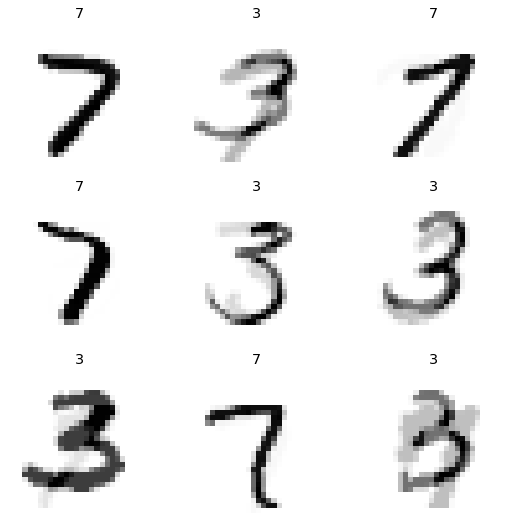

In [19]:
mixup = MixUp(0.75)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 3,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

Label Smoothing

In [23]:
# label smoothing
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.197668,2.792272,0.603509,00:16
1,2.266807,1.877964,0.575439,00:17
2,1.833138,1.569187,0.761404,00:17
3,1.585915,1.247724,0.940351,00:16
4,1.441697,1.138603,0.985965,00:16
